In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
%autoreload 2

print("-- loading modules")
print()

import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
# import datetime as dt
# import time
import sys,os,glob
from mpl_toolkits.basemap import Basemap
import xarray as xr
# from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from setEnv import *
from importingData import *
# from scalingApproximations import *
from slicingAndSubsetting import *
from thermoConstants import L_v,R_v
# from plotMaps import *
from plot1DInvLog import *
# from plot2D import *
from statisticalDistributions import *
from savingResults import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

-- loading modules

Own modules available: ['thermoConstants', 'setEnv', 'thermoFunctions', 'importingData', 'statisticalDistributions', 'plot1DInvLog', 'dataFormat', 'savingResults', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'slicingAndSubsetting', 'thermoFunctionsForMoistAdiabat', 'plot2D']


In [3]:
archivedir = getArchivedir(machine='coriknl')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures')

# Simulation data

In [4]:
# Simulation root name
case = 'RCE'
Nxyz = '256x256x64'
Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
simroot = "RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_%s"%Nxyz
# Experiment name
SST = 300
# expname = "TKE-SST%d-r1"%SST
# expname = "TKE-SST%d-radhomo-r1"%SST
expname = "TKE-SST%d-r1-b150-radagg"%SST
# Simulation full name
simname = "%s_%s"%(simroot,expname)
daymin = 85
daymax = 95
day_ref = 90
hour_ref = day_ref*24
hour_ref_str = str(hour_ref)
dt = 15

In [5]:
figdir = os.path.join(figuredir,simroot,expname)
if not os.path.exists(figdir): os.makedirs(figdir)
    
resdir = os.path.join(resultdir,simroot,expname)
if not os.path.exists(resdir): os.makedirs(resdir)

In [6]:
figsubdir_contributions = os.path.join(figdir,'dynamic_thermo_contributions')
if not os.path.exists(figsubdir_contributions): os.makedirs(figsubdir_contributions)

In [7]:
dT = 10 # days
sT_ref = slice(daymin*24,daymax*24)

In [8]:
print("Load data")
steprange = (daymin*24*3600/dt,daymax*24*3600/dt)
files_in_steprange = get3DFilesBetweenSteps(archivedir,simname,steprange)
file_pattern_2D = os.path.join(archivedir,simname,'OUT_2D','%s_%d.2Dcom_*.nc'%(simname,Nproc))
ds_3D = xr.open_mfdataset(files_in_steprange,decode_cf=False)
var2drop = ['PBLH', 'SHF', 'LHF', 'LWNS', 'LWNSC', 'LWNT', 'LWNTC',\
            'SOLIN', 'SWNS', 'SWNSC', 'SWNT', 'SWNTC', 'CWP', 'IWP', 'CLD', 'USFC', 'U200',\
            'VSFC', 'V200', 'W730', 'PSFC', 'SWVP', 'U850', 'V850', 'ZC', 'TB', 'ZE']
ds_2D = xr.open_mfdataset(file_pattern_2D,decode_cf=False,data_vars=['Prec'],drop_variables=var2drop)
pr = ds_2D.Prec[sT_ref]

Load data


# Stats

In [9]:
print("Load reference precipitation statistics")
resultsubdir = os.path.join(resultdir,simroot,expname,'xy_stats_over_time')
perc_ILQ_pr = pickle.load(open(os.path.join(resultsubdir,'percentiles_ILQ_pr.pickle'),'rb'))
ranks_ILQ_pr = pickle.load(open(os.path.join(resultsubdir,'ranks_ILQ_pr.pickle'),'rb'))
bins_ILQ_pr = pickle.load(open(os.path.join(resultsubdir,'bins_ILQ_pr.pickle'),'rb'))

Load reference precipitation statistics


In [10]:
print("Define reference ranks and location of extremes")

Q_IL = ranks_ILQ_pr[hour_ref_str]
Qmax = 99.99
iQmax = indexOfRank(Qmax,Q_IL)
ranks_ref = Q_IL[:iQmax]
Qmin = 90
iQmin = indexOfRank(Qmin,Q_IL)
targetranks = Q_IL[iQmin:iQmax]

# ranks_ref = Q_IL[iQmin:iQmax]

Define reference ranks and location of extremes


In [11]:
print("Find location of extremes")

ranks = ranks_ILQ_pr[hour_ref_str]
bins = bins_ILQ_pr[hour_ref_str]

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr.data,ranks,bins,rank_locations)
print()

Find location of extremes
20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 


In [12]:
print("Find location of extremes shifted by an hour")

rank_locations_m1h= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations_m1h[rank_id] = getRankLocations(rank,pr.data,ranks,bins,rank_locations_m1h,time_shift=-1)
print()

Find location of extremes shifted by an hour
20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 


In [13]:
print("compute sample size in each bin")
N_prQ = sampleSizeAtAllRanks(targetranks,pr.data,ranks_ref,bins=bins,rank_locations=rank_locations)

compute sample size in each bin


> Plot sample size in each percentile bin


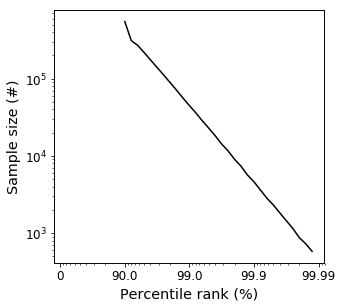

In [14]:
print("> Plot sample size in each percentile bin")

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,4.5))

ax.set_yscale('log')

# Add zero line
addZeroLine(ax,ranks_ref)

# Grey shading
# i_Q_lims = (iQ_slice.start, iQ_slice.stop-1)
# subplotXShadingRanksILog(ax,ranks_ref,i_Q_lims,alpha=0.15,transformX=False)

subplotRanksILog(ax,ranks_ref,
                 N_prQ,
                 col='k',ltype='-',transformX=True)

# addXHatchRanksILog(ax,ranks_ref,(0,iQmin),alpha=0.2,transformX=True)

ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Sample size (#)')

plt.show()

In [15]:
w_prQ = meanXProfileAtAllYRanks(targetranks,ds_3D.W.data.compute(),pr.data.compute(),ranks,bins,rank_locations)
temp_prQ = meanXProfileAtAllYRanks(targetranks,ds_3D.TABS.data.compute(),pr.data.compute(),ranks,bins,rank_locations)

In [16]:
w_prQ_m1h = meanXProfileAtAllYRanks(targetranks,ds_3D.W.data.compute(),pr.data.compute(),ranks,bins,rank_locations_m1h)
temp_prQ_m1h = meanXProfileAtAllYRanks(targetranks,ds_3D.TABS.data.compute(),pr.data.compute(),ranks,bins,rank_locations_m1h)

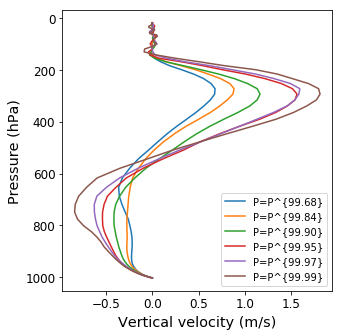

In [17]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(5,5))
for i in (24,27,29,32,34,38):
    plt.plot(w_prQ[i],ds_3D.p[0],label=r'P=P^{%2.2f}'%ranks[i])
ax.legend()
ax.invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Vertical velocity (m/s)")
plt.savefig(os.path.join(figsubdir_contributions,"conditional_w_profile_various_extremes.pdf"),bbox_layout='tight')
plt.show()

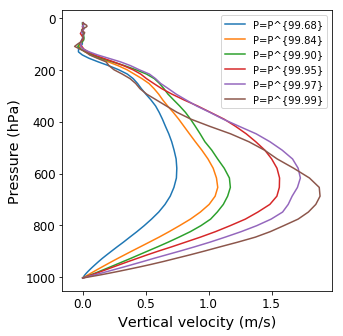

In [18]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(5,5))
for i in (24,27,29,32,34,38):
    plt.plot(w_prQ_m1h[i],ds_3D.p[0],label=r'P=P^{%2.2f}'%ranks[i])
ax.legend()
ax.invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Vertical velocity (m/s)")
plt.savefig(os.path.join(figsubdir_contributions,"conditional_w_profile_various_extremes_1h_before.pdf"),bbox_layout='tight')
plt.show()

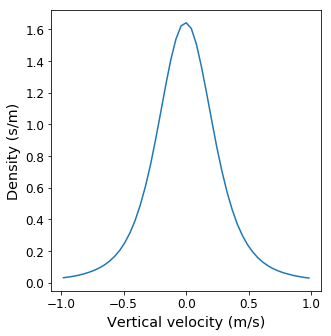

In [19]:
k500 = np.argmin(np.abs(np.mean(ds_3D.p.data,axis=0) - 500 )).compute()
z500 = ds_3D.z[k500]
ranks, percentiles, bins, densities = compute1dDensities(ds_3D.W.sel(z = z500).data.compute(),vmin = -1,vmax = 1)
plt.figure(figsize=(5,5))
plt.plot(percentiles,densities)
plt.ylabel('Density (s/m)')
plt.xlabel('Vertical velocity (m/s)')
plt.savefig(os.path.join(figsubdir_contributions,"distribution_w500.pdf"),bbox_layout='tight')
plt.show()

# Scaling

In [ ]:
# FOR EXAMPLE
eps_OGS09, pr_scOGS09_vQ = computeScalingOGS09AtAllRanks(targetranks,omega,ta,pres,pr,
    ranks_ref=ranks_ref[iQ_slice],percentiles_ref=percentiles[iQ_slice],bins=bins,
                                                         rank_locations=rank_locations)

In [ ]:
# OR MAYBE
